# Data Augmentation For BEV Dataset

¿Qué técnicas de aumento de datos podemos utilizar para imágenes Bird's-Eye-View?

In [1]:
import numpy as np
import pandas as pd


from torchvision.transforms import v2

from PIL import Image
import cv2

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import sys
import os

warnings.filterwarnings('ignore')
%cd /workspaces/bev2seg_2/

# Import like this to avoid getting /libraries/oldatasets
sys.path.insert(0, "/workspaces/bev2seg_2")
if "oldatasets" in sys.modules:
    del sys.modules["oldatasets"]
from oldatasets.BEV import BEVDataset
from oldatasets.NuImages import NuImagesFormattedDataset
import oldatasets
print(oldatasets.__path__)

BEVDATASET_PATH = "./tmp/BEVDataset"
NUIMAGESF_PATH  = "./tmp/NuImagesFormatted"

def show_dataset_images(dataset, title:str=""):
    f, axes = plt.subplots(2, 8, figsize=(10, 5))
    for i in range(len(dataset)):
        image, target = dataset[i]

        color_mask_bgr = dataset.target2image(np.asarray(target))
        target = Image.fromarray(cv2.cvtColor(color_mask_bgr, cv2.COLOR_BGR2RGB))

        axes[0, i].imshow(image)
        axes[1, i].imshow(target)
        axes[0, i].axis('off')
        axes[1, i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.1, wspace=0.1)
    plt.show()

def clean_folder(path:str):
    assert os.path.exists(path)
    files = os.listdir(path)
    if len(files) > 0:
        for f in tqdm(files, desc=f"Removing files from {path}"):
            file_path = os.path.join(path, f)
            assert os.path.exists(file_path)
            os.remove(file_path)


/workspaces/bev2seg_2
_NamespacePath(['/workspaces/bev2seg_2/oldatasets', '/libraries/oldatasets', '/workspaces/bev2seg_2/oldatasets'])


Generating Augmentations: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


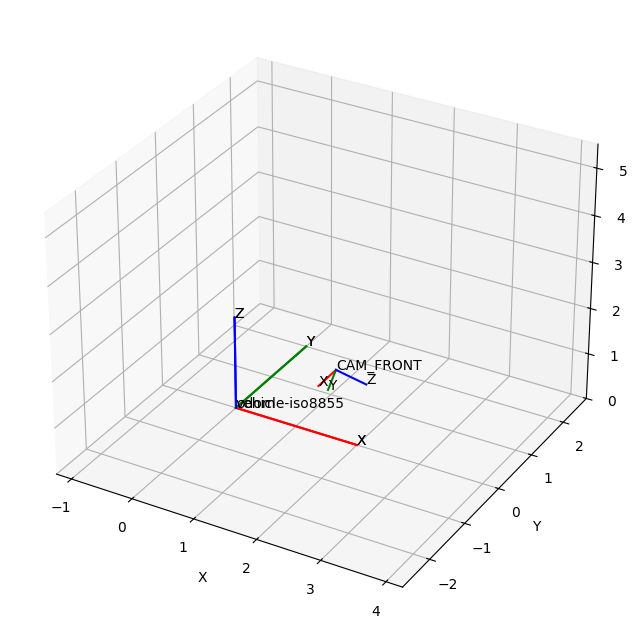

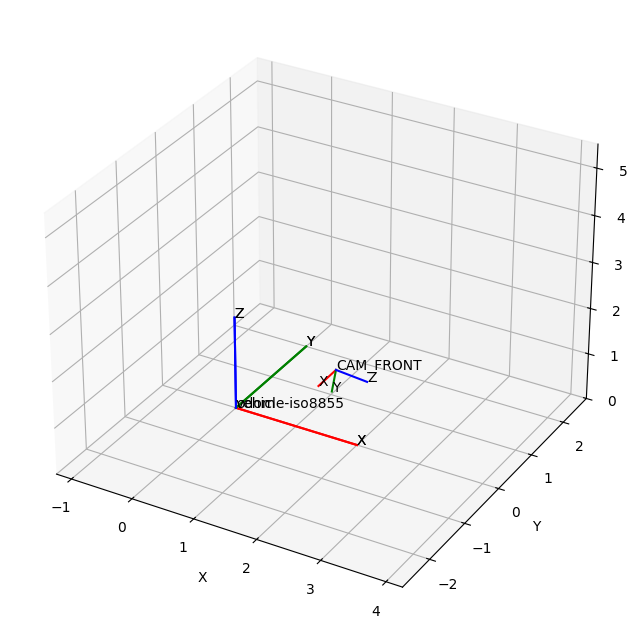

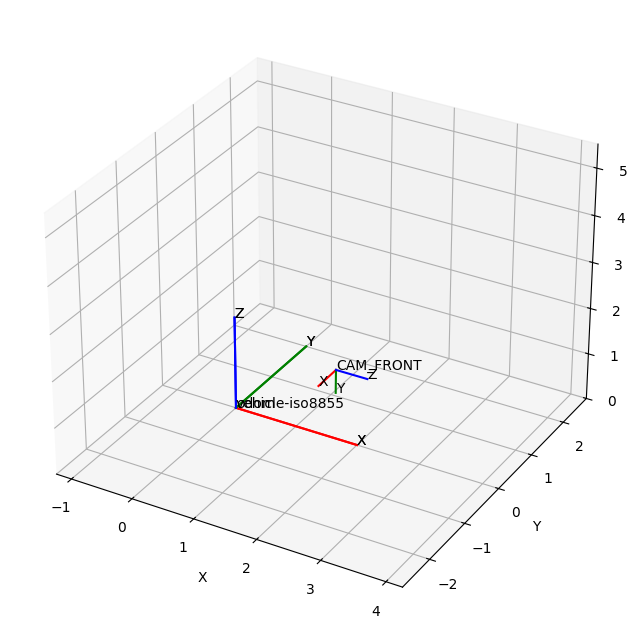

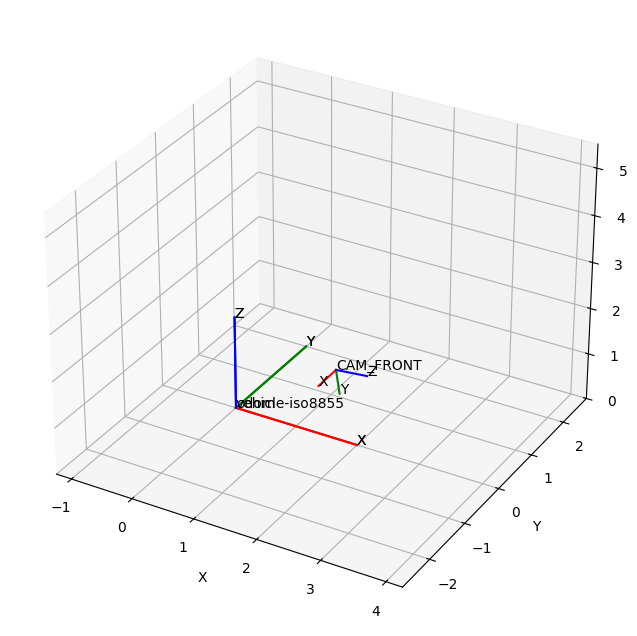

In [27]:
t = {
    'multiple_rotations':True,
    'use_random': False,
    'save_scene_path': None,
    'rx': 0.0,
    'ry': 0.0,
    'rz': 0.0
}
num_aug = 5 # 100
dataset = BEVDataset(dataroot=BEVDATASET_PATH, version='mini', transforms=t)
values  = np.linspace(-0.25, 0.25, num_aug)
# print(f"values: {values}")

axis = 'ry'
image_index = 6
out_path = os.path.join("tmp", axis) 
clean_folder(out_path)

for i, v in enumerate(tqdm(values, desc="Generating Augmentations")):
    dataset.transforms['save_scene_path'] = os.path.join(out_path, f"scene_{i}.png")
    dataset.transforms[axis] = v
    image, target = dataset[image_index]
    image.save(os.path.join(out_path, f"image_{axis}_{v}_{i}.png"))

    color_mask_bgr = dataset.target2image(np.asarray(target))
    target = Image.fromarray(cv2.cvtColor(color_mask_bgr, cv2.COLOR_BGR2RGB))
    target.save(os.path.join(out_path, f"mask_{axis}_{v}_{i}.png"))
plt.close()


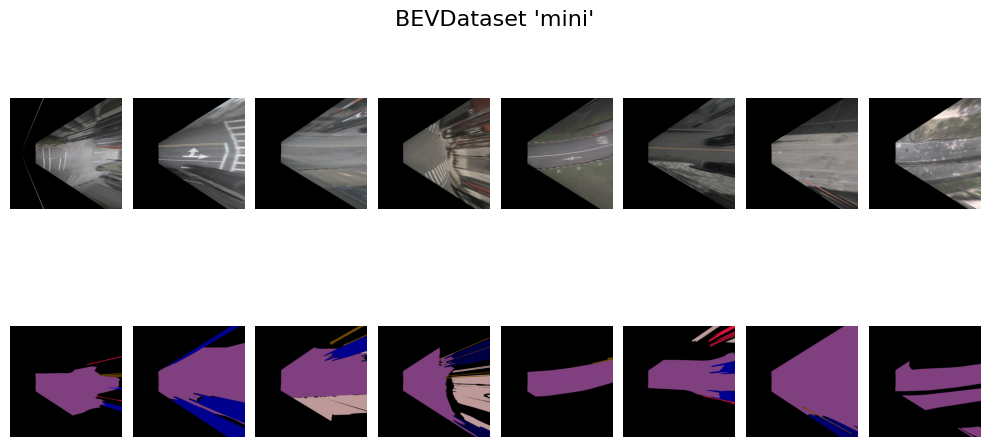

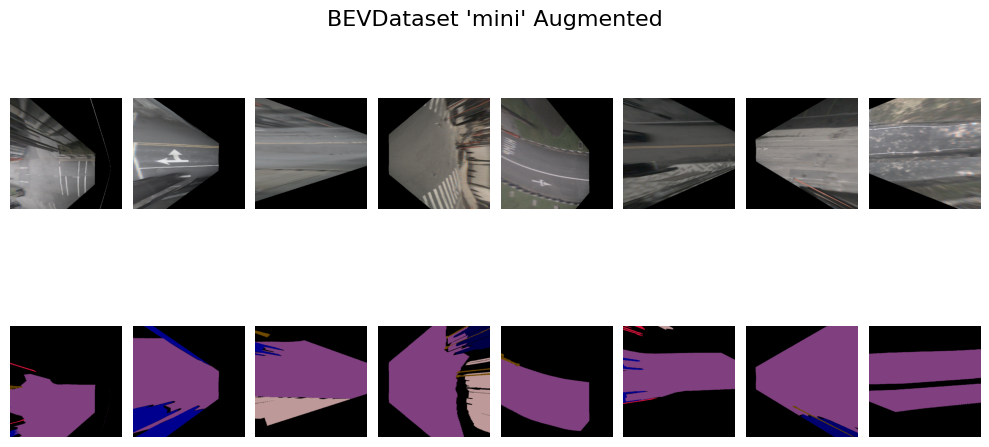

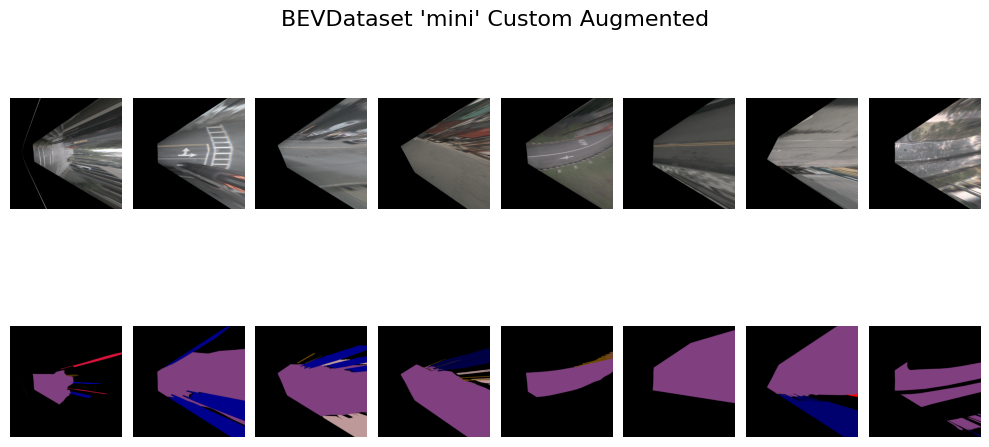

In [7]:
bev_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(512, 512), ratio=(0.5, 2.0), interpolation=v2.InterpolationMode.NEAREST),
    v2.RandomHorizontalFlip(p=0.5)
    ])

bev_transforms2 = {
    'multiple_rotations':False,
    'use_random': True,
    'rx': (0.0, 0.0),
    'ry': (-0.25, 0.25),
    'rz': (-0.25, 0.25) # (-0.15, 0.15)
}

dataset_bev     = BEVDataset(dataroot=BEVDATASET_PATH, version='mini', transforms=None)
dataset_bev_t   = BEVDataset(dataroot=BEVDATASET_PATH, version='mini', transforms=bev_transforms)
dataset_bev_t2   = BEVDataset(dataroot=BEVDATASET_PATH, version='mini', transforms=bev_transforms2)
show_dataset_images(dataset_bev, title="BEVDataset 'mini'")
show_dataset_images(dataset_bev_t, title="BEVDataset 'mini' Augmented")
show_dataset_images(dataset_bev_t2, title="BEVDataset 'mini' Custom Augmented")

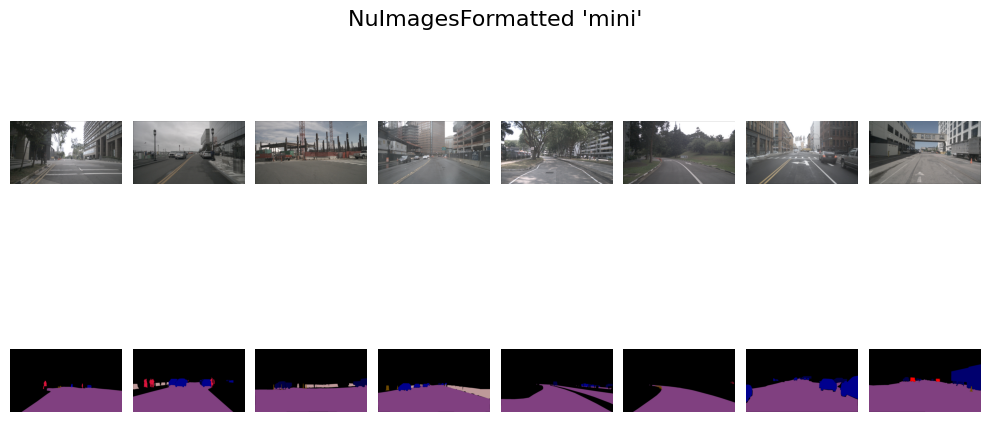

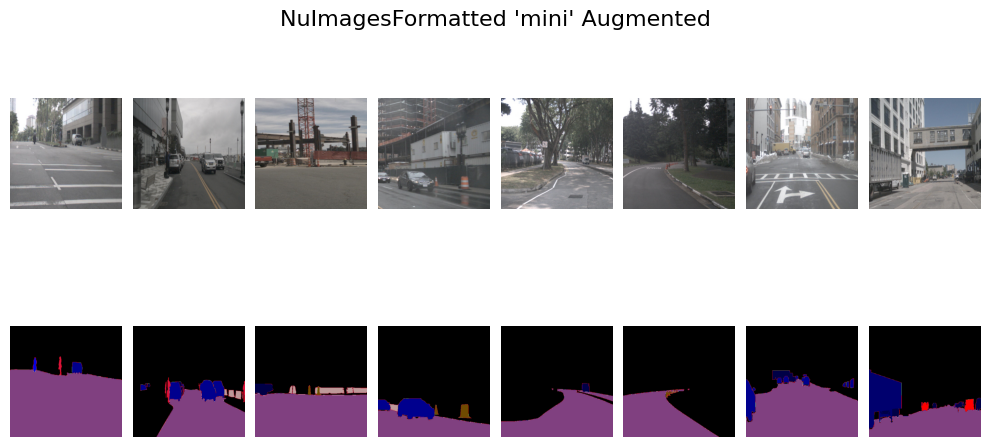

In [22]:
nu_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(512, 512), ratio=(0.5, 2.0)),
    v2.RandomHorizontalFlip(p=0.5)
    ])

dataset_nu      = NuImagesFormattedDataset(dataroot=NUIMAGESF_PATH, version='mini', transforms=None)
dataset_nu_t    = NuImagesFormattedDataset(dataroot=NUIMAGESF_PATH, version='mini', transforms=nu_transforms)
show_dataset_images(dataset_nu, title="NuImagesFormatted 'mini'")
show_dataset_images(dataset_nu_t, title="NuImagesFormatted 'mini' Augmented")

In [6]:
phases = 10
data_aug_path = os.path.join("tmp", "data_aug")
clean_folder(data_aug_path)

for p in range(phases):
    for i in range(len(dataset_bev_t)):
        image, target = dataset_bev_t[i]
        image.save(os.path.join(data_aug_path, f"bev_crop_image_{i}_{p}.png"))

        color_mask_bgr = dataset_bev_t.target2image(np.asarray(target))
        target = Image.fromarray(cv2.cvtColor(color_mask_bgr, cv2.COLOR_BGR2RGB))
        target.save(os.path.join(data_aug_path, f"bev_crop_mask_{i}_{p}.png"))